In [1]:
# fix phase space distribution (not a complete fix)

import numpy as np
from astropy.utils.misc import NumpyRNGContext
from halotools.empirical_models.phase_space_models.analytic_models.monte_carlo_helpers import MonteCarloGalProf

def mc_unit_sphere_corrected(self, Npts, **kwargs):
    seed = kwargs.get('seed', None)

    with NumpyRNGContext(seed):
        cos_t = np.random.uniform(-1., 1., Npts)
    if seed is not None:
        seed += 1
    with NumpyRNGContext(seed):
        phi = np.random.uniform(0, 2*np.pi, Npts)
    sin_t = np.sqrt((1.-cos_t*cos_t))

    x = sin_t * np.cos(phi)
    y = sin_t * np.sin(phi)
    z = cos_t

    return x, y, z

MonteCarloGalProf.mc_unit_sphere = mc_unit_sphere_corrected

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# fix poisoon distribution when seed is specified

import numpy as np
from astropy.utils.misc import NumpyRNGContext
from halotools.empirical_models.occupation_models.occupation_model_template import OccupationComponent
from scipy.special import pdtrik

def _poisson_distribution_corrected(self, first_occupation_moment, seed=None, **kwargs):
    with NumpyRNGContext(seed):
        result = np.ceil(pdtrik(np.random.rand(*first_occupation_moment.shape),
                                first_occupation_moment)).astype(np.int)
    if 'table' in kwargs:
        kwargs['table']['halo_num_'+self.gal_type] = result
    return result

OccupationComponent._poisson_distribution = _poisson_distribution_corrected

In [4]:
# fix assembias decorator

from halotools.empirical_models.assembias_models.heaviside_assembias import HeavisideAssembias
from halotools.utils.array_utils import custom_len
from halotools.custom_exceptions import HalotoolsError
from halotools.utils.table_utils import compute_conditional_percentiles

def assembias_decorator_corrected(self, func):
    lower_bound_key = 'lower_bound_' + self._method_name_to_decorate + '_' + self.gal_type
    baseline_lower_bound = getattr(self, lower_bound_key)
    upper_bound_key = 'upper_bound_' + self._method_name_to_decorate + '_' + self.gal_type
    baseline_upper_bound = getattr(self, upper_bound_key)

    def wrapper(*args, **kwargs):

        #################################################################################
        # Retrieve the arrays storing prim_haloprop and sec_haloprop
        # The control flow below is what permits accepting an input
        # table or a directly inputting prim_haloprop and sec_haloprop arrays
        _HAS_table = False
        if 'table' in kwargs:
            try:
                table = kwargs['table']
                prim_haloprop = table[self.prim_haloprop_key]
                sec_haloprop = table[self.sec_haloprop_key]
                _HAS_table = True
            except KeyError:
                msg = ("When passing an input ``table`` to the "
                    " ``assembias_decorator`` method,\n"
                    "the input table must have a column with name ``%s``"
                    "and a column with name ``%s``.\n")
                raise HalotoolsError(msg % (self.prim_haloprop_key), self.sec_haloprop_key)
        else:
            try:
                prim_haloprop = np.atleast_1d(kwargs['prim_haloprop'])
            except KeyError:
                msg = ("\nIf not passing an input ``table`` to the "
                    "``assembias_decorator`` method,\n"
                    "you must pass ``prim_haloprop`` argument.\n")
                raise HalotoolsError(msg)
            try:
                sec_haloprop = np.atleast_1d(kwargs['sec_haloprop'])
            except KeyError:
                if 'sec_haloprop_percentile' not in kwargs:
                    msg = ("\nIf not passing an input ``table`` to the "
                        "``assembias_decorator`` method,\n"
                        "you must pass either a ``sec_haloprop`` or "
                        "``sec_haloprop_percentile`` argument.\n")
                    raise HalotoolsError(msg)

        #################################################################################

        # Compute the fraction of type-2 halos as a function of the input prim_haloprop
        split = self.percentile_splitting_function(prim_haloprop)

        # Compute the baseline, undecorated result
        result = func(*args, **kwargs)

        # We will only decorate values that are not edge cases,
        # so first compute the mask for non-edge cases
        no_edge_mask = (
            (split > 0) & (split < 1) &
            (result > baseline_lower_bound) & (result < baseline_upper_bound)
            )
        # Now create convenient references to the non-edge-case sub-arrays
        no_edge_result = result[no_edge_mask]
        no_edge_split = split[no_edge_mask]

        #################################################################################
        # Compute the array type1_mask
        # This array will serve as a boolean mask that divides the halo sample into two subsamples
        # There are several possible ways that the type1_mask can be computed, depending on
        # what the decorator was passed as input

        if _HAS_table is True:
            # we were passed halo_type_tuple:
            if hasattr(self, 'halo_type_tuple'):
                halo_type_key = self.halo_type_tuple[0]
                halo_type1_val = self.halo_type_tuple[1]
                type1_mask = table[halo_type_key][no_edge_mask] == halo_type1_val

            # the value of sec_haloprop_percentile is already stored as a column of the table
            elif self.sec_haloprop_key + '_percentile' in list(table.keys()):
                no_edge_percentiles = table[self.sec_haloprop_key + '_percentile'][no_edge_mask]
                type1_mask = no_edge_percentiles > no_edge_split
            else:
                # the value of sec_haloprop_percentile will be computed from scratch
                percentiles = compute_conditional_percentiles(
                    prim_haloprop=prim_haloprop,
                    sec_haloprop=sec_haloprop
                    )
                no_edge_percentiles = percentiles[no_edge_mask]
                type1_mask = no_edge_percentiles > no_edge_split
        else:
            try:
                percentiles = kwargs['sec_haloprop_percentile']
                if custom_len(percentiles) == 1:
                    percentiles = np.zeros(custom_len(prim_haloprop)) + percentiles
            except KeyError:
                percentiles = compute_conditional_percentiles(
                    prim_haloprop=prim_haloprop,
                    sec_haloprop=sec_haloprop
                    )
            no_edge_percentiles = percentiles[no_edge_mask]
            type1_mask = no_edge_percentiles > no_edge_split

        # type1_mask has now been computed for all possible branchings
        #################################################################################

        perturbation = self._galprop_perturbation(
                prim_haloprop=prim_haloprop[no_edge_mask],
                baseline_result=no_edge_result,
                splitting_result=no_edge_split)

        frac_type1 = 1 - no_edge_split
        frac_type2 = 1 - frac_type1
        perturbation[~type1_mask] *= (-frac_type1[~type1_mask] /
            (frac_type2[~type1_mask]))

        perturbation -= perturbation.mean(dtype=np.float64)
        original_result = result.copy()
        no_edge_result += perturbation
        result[no_edge_mask] = no_edge_result
        result[result < 0] = 0
        result *= original_result.sum() / result.sum()

        if getattr(self, 'preserve_mc_occupation', None):
            self.assembias_mean_occupation = result
            return original_result

        return result

    return wrapper

HeavisideAssembias.assembias_decorator = assembias_decorator_corrected


class PreservingNgalHeavisideAssembias(HeavisideAssembias):
    preserve_mc_occupation = True

    def assembias_mc_occupation(self, seed=None, **kwargs):
        first_occupation_moment_orig = self.mean_occupation(**kwargs)
        first_occupation_moment = self.assembias_mean_occupation
        if self._upper_occupation_bound == 1:
            n = custom_len(first_occupation_moment_orig)
            with NumpyRNGContext(seed):
                score = np.random.rand(n)
            result = np.zeros(n, np.int)
            total = np.count_nonzero(first_occupation_moment_orig >= score)
            result[(first_occupation_moment / score).argsort()[-total:]] = 1
            return result
        elif self._upper_occupation_bound == float("inf"):
            total = self._poisson_distribution(first_occupation_moment_orig.sum(), seed=seed)
            if seed is not None:
                seed += 1
            with NumpyRNGContext(seed):
                score = np.random.rand(total)
            score.sort()
            x = first_occupation_moment.cumsum() / first_occupation_moment.sum()
            return np.ediff1d(np.insert(np.searchsorted(score, x), 0, 0))
        else:
            msg = ("\nYou have chosen to set ``_upper_occupation_bound`` to some value \n"
                "besides 1 or infinity. In such cases, you must also \n"
                "write your own ``mc_occupation`` method that overrides the method in the \n"
                "OccupationComponent super-class\n")
            raise HalotoolsError(msg)

    def _decorate_baseline_method(self):
        super(PreservingNgalHeavisideAssembias, self)._decorate_baseline_method()
        self.mc_occupation = self.assembias_mc_occupation


In [5]:
from halotools.empirical_models import Zheng07Cens, Zheng07Sats

class PreservingNgalAssembiasZheng07Cens(Zheng07Cens, PreservingNgalHeavisideAssembias):
    def __init__(self, **kwargs):
        Zheng07Cens.__init__(self, **kwargs)
        PreservingNgalHeavisideAssembias.__init__(self,
            lower_assembias_bound=self._lower_occupation_bound,
            upper_assembias_bound=self._upper_occupation_bound,
            method_name_to_decorate='mean_occupation', **kwargs)
        
class PreservingNgalAssembiasZheng07Sats(Zheng07Sats, PreservingNgalHeavisideAssembias):
    def __init__(self, **kwargs):
        Zheng07Sats.__init__(self, **kwargs)
        PreservingNgalHeavisideAssembias.__init__(self,
            lower_assembias_bound=self._lower_occupation_bound,
            upper_assembias_bound=self._upper_occupation_bound,
            method_name_to_decorate='mean_occupation', **kwargs)

In [6]:
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace
from halotools.empirical_models import HodModelFactory

class HODMock(object):
    default_model_kwargs = {
        'centrals_occupation':   PreservingNgalAssembiasZheng07Cens(prim_haloprop_key='halo_mvir', sec_haloprop_key='halo_nfw_conc'),
        'satellites_occupation': PreservingNgalAssembiasZheng07Sats(prim_haloprop_key='halo_mvir', sec_haloprop_key='halo_nfw_conc'),
        'centrals_profile': TrivialPhaseSpace(),
        'satellites_profile': NFWPhaseSpace()
    }
    
    default_model_params = {
        'alpha': 1.33738,
        'logM1': 13.98811,
        'sigma_logM': 0.5595,
        'logM0': 11.95797,
        'logMmin': 12.82356,
        'mean_occupation_centrals_assembias_param1': 0.0,
        'mean_occupation_satellites_assembias_param1': 0.0,
    }
    
    param_name_translate = {
        'sigma': 'sigma_logM',
        'Acen': 'mean_occupation_centrals_assembias_param1',
        'Asat': 'mean_occupation_satellites_assembias_param1',
        'A_cen': 'mean_occupation_centrals_assembias_param1',
        'A_sat': 'mean_occupation_satellites_assembias_param1',
    }
    
    def __init__(self, halocat, default_seed=None, default_model_params=None, **kwargs):
        self.halocat = halocat
        self.default_seed = default_seed
        self.model = HodModelFactory(**dict(self.default_model_kwargs, **kwargs))
        if default_model_params:
            self.default_model_params.update(default_model_params)

    def update_params(self, **params):
        params = {self.param_name_translate.get(k, k): v for k, v in params.items()}
        self.model.param_dict.update(dict(self.default_model_params, **params))
                
    def populate(self, seed=None, **update_params):
        seed = self.default_seed if seed is None else seed
        self.update_params(**update_params)
        try:
            self.model.mock.populate(seed=seed)
        except AttributeError:
            self.model.populate_mock(self.halocat, seed=seed)
                
    def get_ngals(self, seed=None, **update_params):
        self.populate(seed=seed, **update_params)
        return len(self.galaxy_table)
        
    @property
    def galaxy_table(self):
        return self.model.mock.galaxy_table

In [7]:
from halotools.sim_manager import CachedHaloCatalog

halocat = CachedHaloCatalog(simname='bolplanck', version_name='halotools_v0p4', redshift=0, halo_finder='rockstar')

In [8]:
model = HODMock(halocat, default_seed=12345)

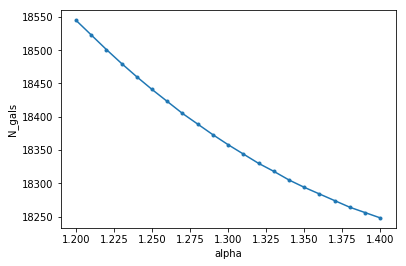

In [24]:
x = np.linspace(1.2, 1.4, 21)
output = [model.get_ngals(alpha=x_this) for x_this in x]
plt.plot(x, output,'.-');
plt.xlabel('alpha');
plt.ylabel('N_gals');

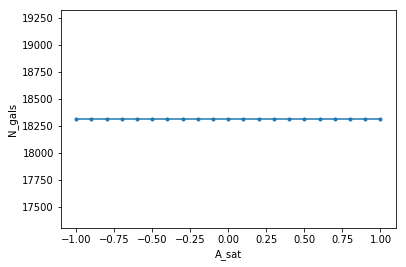

In [25]:
x = np.linspace(-1, 1, 21)
output = [model.get_ngals(A_sat=x_this) for x_this in x]
plt.plot(x, output,'.-');
plt.xlabel('A_sat');
plt.ylabel('N_gals');

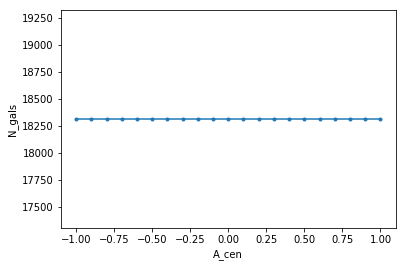

In [26]:
x = np.linspace(-1, 1, 21)
output = [model.get_ngals(A_cen=x_this) for x_this in x]
plt.plot(x, output,'.-');
plt.xlabel('A_cen');
plt.ylabel('N_gals');

In [13]:
from halotools.mock_observables import wp

In [14]:
from halotools.mock_observables import return_xyz_formatted_array

In [15]:
Lbox = 250
pi_max = 60
r_wp = np.logspace(-1, 1.5, 10)

In [16]:
wp_alpha = np.zeros((21,9))
x = np.linspace(1.2, 1.4, 21)
for i,x_this in enumerate(x):
    print(model.get_ngals(alpha=x_this))
    pos_gals_d = return_xyz_formatted_array(*(model.galaxy_table[ax] for ax in 'xyz'), \
            velocity=model.galaxy_table['vz'], velocity_distortion_dimension='z',\
                                          period=Lbox)             ##redshift space distorted
    #pos_gals_d = np.array(pos_gals_d,dtype=float)
    wp_alpha[i] = wp(pos_gals_d, r_wp, pi_max, period=Lbox)

18545
18523
18501
18480
18460
18441
18423
18405
18389
18373
18358
18344
18330
18318
18305
18294
18284
18274
18264
18256
18248


In [17]:
r = (r_wp[1:]+r_wp[:-1])/2.

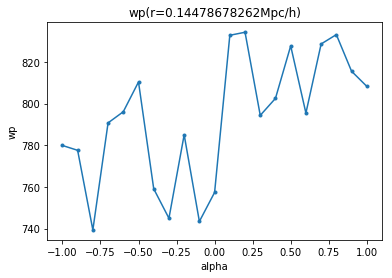

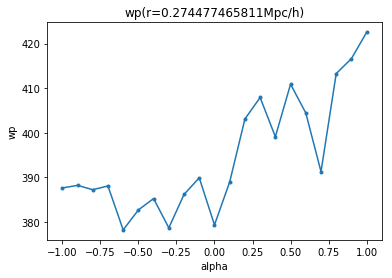

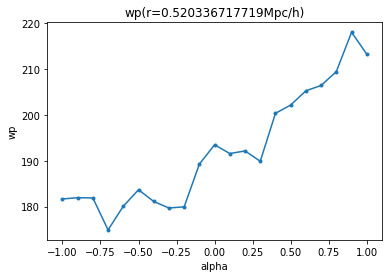

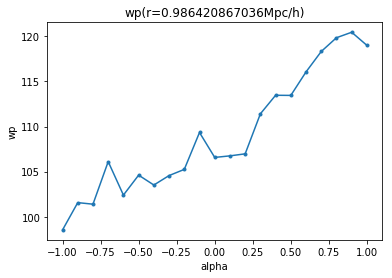

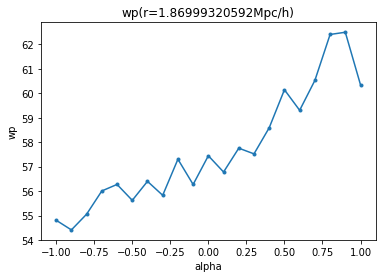

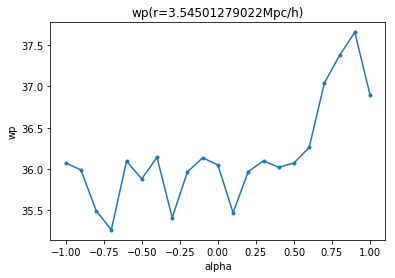

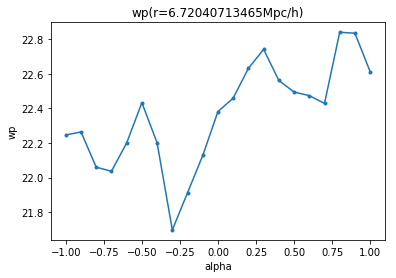

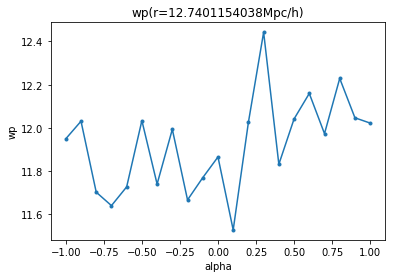

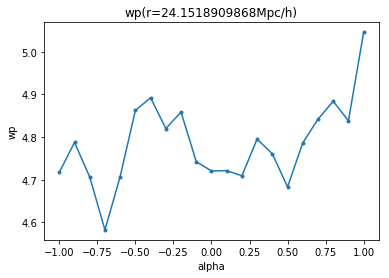

In [27]:
for i in range(9):
    plt.figure()
    plt.plot(x,wp_alpha[:,i],'.-')
    plt.title('wp(r='+str(r[i])+'Mpc/h)')
    plt.xlabel('alpha')
    plt.ylabel('wp')

In [19]:
wp_Acen = np.zeros((21,9))
x = np.linspace(-1, 1, 21)
for i,x_this in enumerate(x):
    print(model.get_ngals(Acen=x_this))
    pos_gals_d = return_xyz_formatted_array(*(model.galaxy_table[ax] for ax in 'xyz'), \
            velocity=model.galaxy_table['vz'], velocity_distortion_dimension='z',\
                                          period=Lbox)             ##redshift space distorted
    #pos_gals_d = np.array(pos_gals_d,dtype=float)
    wp_Acen[i] = wp(pos_gals_d, r_wp, pi_max, period=Lbox)

18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309


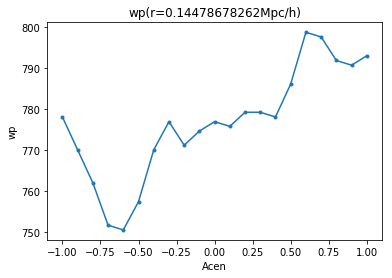

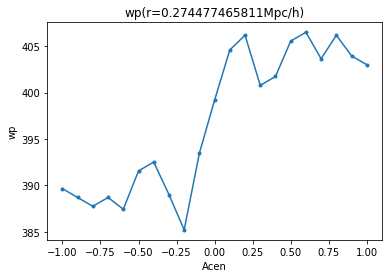

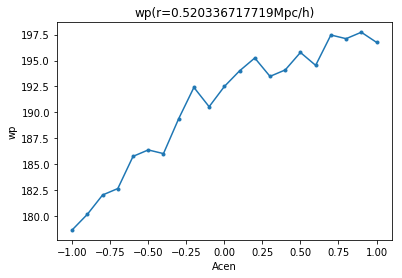

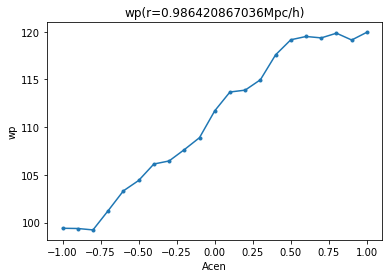

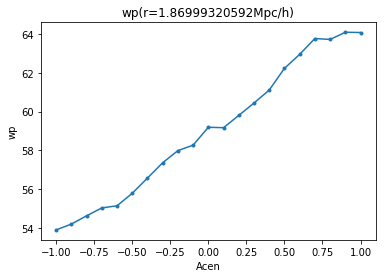

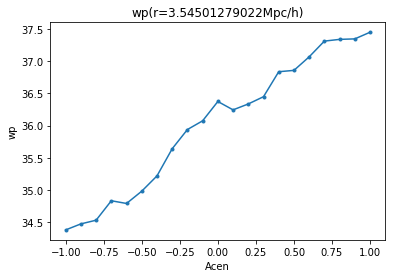

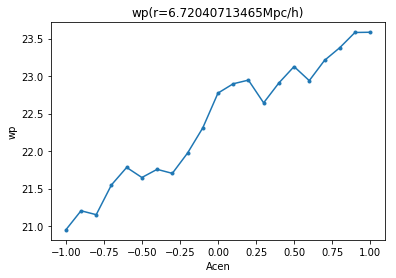

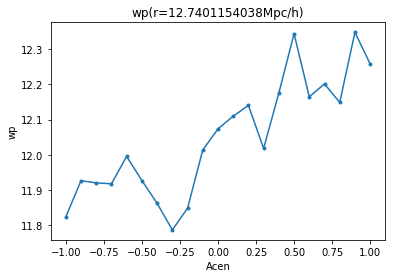

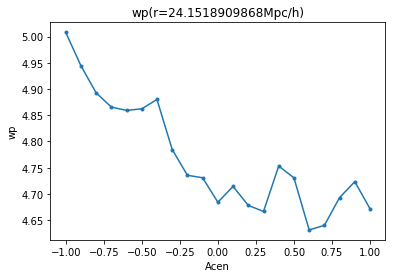

In [28]:
for i in range(9):
    plt.figure()
    plt.plot(x,wp_Acen[:,i],'.-')
    plt.title('wp(r='+str(r[i])+'Mpc/h)')
    plt.xlabel('Acen')
    plt.ylabel('wp')

In [22]:
wp_Asat = np.zeros((21,9))
x = np.linspace(-1, 1, 21)
for i,x_this in enumerate(x):
    print(model.get_ngals(Asat=x_this))
    pos_gals_d = return_xyz_formatted_array(*(model.galaxy_table[ax] for ax in 'xyz'), \
            velocity=model.galaxy_table['vz'], velocity_distortion_dimension='z',\
                                          period=Lbox)             ##redshift space distorted
    #pos_gals_d = np.array(pos_gals_d,dtype=float)
    wp_Asat[i] = wp(pos_gals_d, r_wp, pi_max, period=Lbox)

18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309
18309


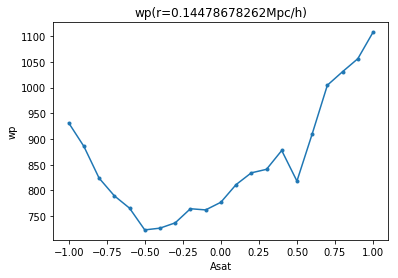

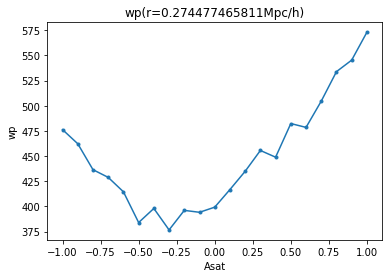

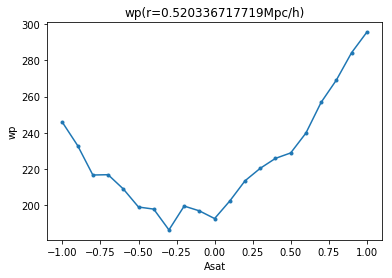

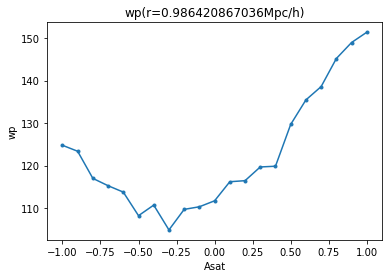

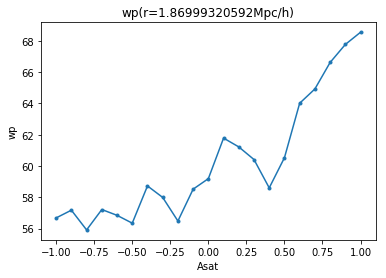

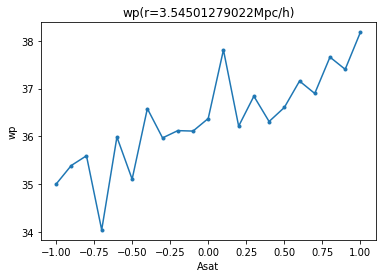

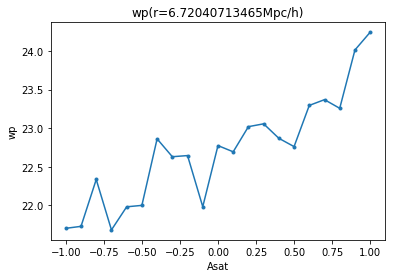

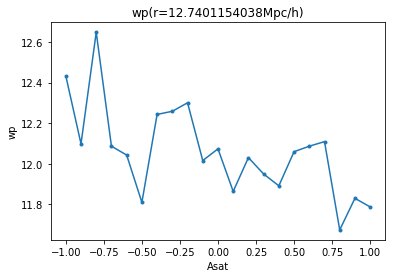

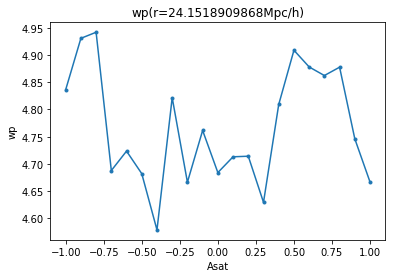

In [30]:
for i in range(9):
    plt.figure()
    plt.plot(x,wp_Asat[:,i],'.-')
    plt.title('wp(r='+str(r[i])+'Mpc/h)')
    plt.xlabel('Asat')
    plt.ylabel('wp')